In [2]:
sc.addPyFile('/local/path/to/sb/soft-boiled.zip')
from src.algorithms import gmm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read Raw Data

In [3]:
data_path = 'hdfs:///post_etl_datasets/twitter/year=2015/month=[4-5]/'
all_tweets = sqlCtx.read.parquet(data_path)
all_tweets.registerTempTable('train_tweets')

In [7]:
data_path = 'hdfs:///datasets/twitter/2015/7/[6-9]/*/*'
all_tweets = sqlCtx.read.json(data_path)
all_tweets.registerTempTable('test_tweets')

#Train Model

In [4]:
# Train GMM model
gmm_model = gmm.train_gmm(sqlCtx, 'train_tweets', ['user.location', 'text'], min_occurrences=7, max_num_components=15)

In [6]:
gmm.save_model(gmm_model, '/local/path/to/save/model.csv.gz')

# Test Model

In [ ]:
original_model = gmm_model

In [ ]:
algorithm_results = []
for model_percentage in np.linspace(.1, 1, 10):
    gmm_model_filtered = {}
    error_at_Nth_percentile = np.percentile([gmm_model[word][1] for word in gmm_model],model_percentage*100.0)
    print 'Error (km) at 75th percentile:', error_at_Nth_percentile
    
    for word in gmm_model:
        if gmm_model[word][1]<=error_at_Nth_percentile:
            gmm_model_filtered[word] = gmm_model[word]
    
    test_results = gmm.run_gmm_test(sc, sqlCtx, 'test_tweets', ['user.location', 'text'], gmm_model_filtered)
    test_results['filtered_percentage'] = model_percentage
    print test_results
    algorithm_results.append(test_results)

Error (km) at 75th percentile: 1.37034897607
('Median Error', 0.90355581252890282)
('Mean Error: ', 659.59289063856795)
{'fields': ['user.location', 'text'], 'median': 0.90355581252890282, 'num_locs': 7732, 'filtered_percentage': 0.10000000000000001, 'coverage': 0.11945186855968731, 'mean': 659.59289063856795}
Error (km) at 75th percentile: 13.8748739418
('Median Error', 5.2862749129272286)
('Mean Error: ', 587.8819211548697)
{'fields': ['user.location', 'text'], 'median': 5.2862749129272286, 'num_locs': 31997, 'filtered_percentage': 0.20000000000000001, 'coverage': 0.4943224829674489, 'mean': 587.8819211548697}
Error (km) at 75th percentile: 128.975806082
('Median Error', 8.8696570176830143)
('Mean Error: ', 709.03347632624195)
{'fields': ['user.location', 'text'], 'median': 8.8696570176830143, 'num_locs': 42698, 'filtered_percentage': 0.30000000000000004, 'coverage': 0.6596425095397735, 'mean': 709.03347632624195}
Error (km) at 75th percentile: 310.91422235
('Median Error', 12.091060

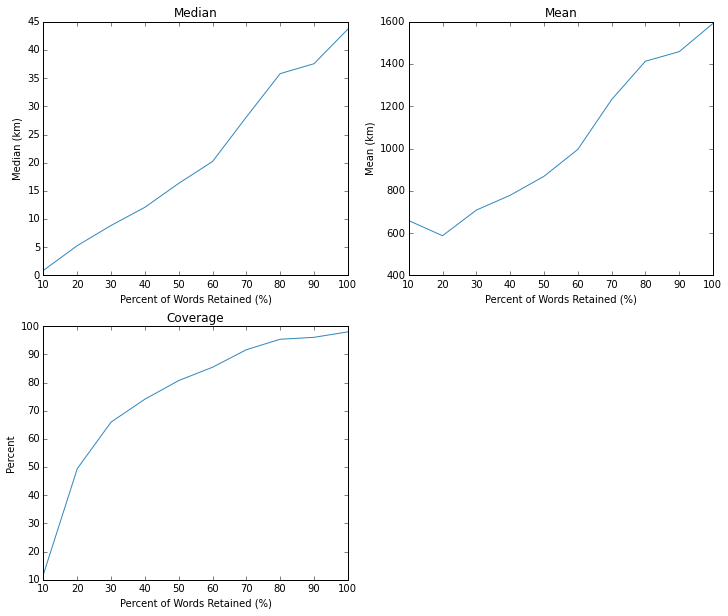

In [21]:
plot_df_vs_gmm_percent(algorithm_results)

In [20]:
from bokeh.palettes import brewer
import pandas as pd
def turn_results_into_dataframe(results):
    fields = results[0].keys()
    vals = {}
    for field in fields:
        vals[field] = []
    for result in results:
        for field in fields:
            vals[field].append(result[field])
    return pd.DataFrame(vals)
def plot_df_vs_gmm_percent(input_data):
    if isinstance(input_data, pd.DataFrame):
        df = input_data
    else:
        df = turn_results_into_dataframe(input_data)
    plt.rcParams['figure.figsize'] = (12.0, 10.0)
    colors =  brewer["Spectral"][10]
    i=1
    plt.subplot(2,2,1)
    plt.plot(df['filtered_percentage']*100.0, df['median'], color=colors[i])
    plt.hold(True)
    plt.ylabel('Median (km)')
    plt.xlabel('Percent of Words Retained (%)')
    plt.title('Median')
    
    plt.subplot(2,2,2)
    plt.plot(df['filtered_percentage']*100.0, df['mean'], color=colors[i])
    plt.hold(True)
    plt.xlabel('Percent of Words Retained (%)')
    plt.ylabel('Mean (km)')
    plt.title('Mean')

    plt.subplot(2,2,3)
    plt.plot(df['filtered_percentage']*100.0, df['coverage']*100.0, color=colors[i])
    plt.hold(True)
    plt.xlabel('Percent of Words Retained (%)')
    plt.ylabel('Percent')
    plt.title('Coverage')

In [23]:
turn_results_into_dataframe(algorithm_results)

,coverage,fields,filtered_percentage,mean,median,num_locs
0,0.119452,"[user.location, text]",0.1,659.592891,0.903556,7732
1,0.494322,"[user.location, text]",0.2,587.881921,5.286275,31997
2,0.659643,"[user.location, text]",0.3,709.033476,8.869657,42698
3,0.740935,"[user.location, text]",0.4,779.221365,12.091061,47960
4,0.806980,"[user.location, text]",0.5,868.953208,16.337430,52235
5,0.854254,"[user.location, text]",0.6,996.142573,20.213556,55295
6,0.916483,"[user.location, text]",0.7,1231.759496,28.106046,59323
7,0.953576,"[user.location, text]",0.8,1413.469362,35.804508,61724
8,0.960358,"[user.location, text]",0.9,1458.769015,37.563502,62163
9,0.979824,"[user.location, text]",1.0,1592.371207,43.686840,63423
